<a href="https://colab.research.google.com/github/Deep-of-Machine/mask_on_off/blob/main/Mask_on_off.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pytorch

# MLP: data loader -> split validation -> openCV  -> data normalized 0 ~ 1 -> model make -> loss, optimizer -> train -> cv2 model predict

# CNN: data loader -> 


In [4]:
import torch
import numpy as np
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F

In [37]:
import cv2

grayImg = cv2.imread('/content/drive/MyDrive/mask_on_off_dataset/dataset/with_mask/image_0.PNG', cv2.IMREAD_GRAYSCALE) 
cv2.imshow('gray', grayImg)
cv2.imwrite('/content/drive/MyDrive/mask_on_off_dataset/dataset_gray/with_mask/image_0.png', grayImg)


DisabledFunctionError: ignored

In [36]:
import cv2
for i in range(220):
    grayImg = cv2.imread(f'/content/drive/MyDrive/mask_on_off_dataset/dataset/with_mask/image_{i}.PNG', cv2.IMREAD_GRAYSCALE) 
    cv2.imshow('gray', grayImg)
    cv2.imwrite(f'/content/drive/MyDrive/mask_on_off_dataset/dataset_gray/with_mask/image_{i}.png', grayImg)


DisabledFunctionError: ignored

In [7]:
trans = transforms.Compose([transforms.Resize((500,500)), 
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

datasets = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/mask_on_off_dataset/dataset/', transform = trans)
classes = ['with_mask', 'without_mask']

In [8]:
datasets

Dataset ImageFolder
    Number of datapoints: 440
    Root location: /content/drive/MyDrive/mask_on_off_dataset/dataset/
    StandardTransform
Transform: Compose(
               Resize(size=(500, 500), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [9]:
train_set, val_set = torch.utils.data.random_split(datasets, [400, 40])

In [10]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=5, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=5, shuffle=False)

In [11]:
len(train_set)

400

In [12]:
len(val_set)

40

In [13]:
for mini_batch in train_loader:
    first_batch = mini_batch
    break

images = first_batch[0]
labels = first_batch[1]

In [14]:
print(len(train_set))
print(len(val_set))

400
40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


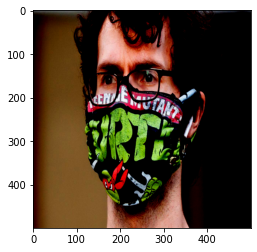

In [15]:
plt.imshow(np.transpose(images[0].numpy(), (1,2,0)))
plt.show()

In [26]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.layer1 = nn.Linear(500*500, 128)
        self.layer2 = nn.Linear(128, 32)
        self.layer3 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        out = self.layer3(x)

        return out

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [28]:
model = MyNet().to(device)

In [29]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

32004322


In [30]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005) 

In [31]:
import time
def train():
    model.train()
    start_time = time.time()
    train_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = torch.argmax(outputs, dim = 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()

    return train_loss/len(train_loader), 100*correct / total, end_time - start_time

In [32]:
def validation():
    model.eval()
    start_time = time.time()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            val_loss += loss.item()
            predicted = torch.argmax(outputs, dim = 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    end_time = time.time()

    return val_loss/len(val_loader), 100*correct / total, end_time - start_time

In [33]:
epochs = 200
max_val_acc = 0

train_losses = []
val_losses = []
train_acces = []
val_acces = []


for epoch in range(epochs):
    train_loss, train_acc, train_time = train()
    print('Epoch : {}, Train loss : {}, acc : {}, time : {}'.format(epoch + 1, train_loss, train_acc, train_time))
    train_losses.append(train_loss)
    train_acces.append(train_acc)
    
    val_loss, val_acc, val_time = validation()
    print('      Validation loss : {}, acc : {}, time : {}'.format(val_loss, val_acc, val_time))
    val_losses.append(val_loss)
    val_acces.append(val_acc)
    
    #scheduler.step()
    
    if val_acc >= max_val_acc: # 가장 평가 성능이 좋은 모델을 저장
        PATH = f'/content/drive/MyDrive/Mask_model/ResNet18_2_{val_acc}.pth'
        torch.save(model.state_dict(), PATH)
        max_val_acc = val_acc

RuntimeError: ignored

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim = 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(total)
    print(100*correct / total)